<a href="https://colab.research.google.com/github/Sorrakit-Bank100/CNN_DeepLearning_Project/blob/main/Bone_Break_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/pkdarabi/bone-break-classification-image-dataset/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: Sbank
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/pkdarabi/bone-break-classification-image-dataset


100%|██████████| 28.4M/28.4M [00:00<00:00, 1.60GB/s]

In [ ]:
import torch
from torch import nn
from torch.optim import Adam
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import os
from torchvision import models

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device available: ", device)

Device available:  cuda


In [ ]:
image_path = []
labels = []

base_dir = "/content/bone-break-classification-image-dataset/Bone Break Classification/Bone Break Classification"

for class_name in os.listdir(base_dir):
    class_path = os.path.join(base_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    for split_type in os.listdir(class_path):  # This will be 'Train' or 'Test'
        split_path = os.path.join(class_path, split_type)
        if not os.path.isdir(split_path):
            continue

        for image_file_name in os.listdir(split_path):
            img_path = os.path.join(split_path, image_file_name)
            if os.path.isfile(img_path):
                image_path.append(img_path)
                labels.append(class_name) # Append the actual class name as the label

data_df = pd.DataFrame(zip(image_path, labels), columns = ['image_paths', 'labels'])
data_df.head()

,image_paths,labels
0,/content/bone-break-classification-image-datas...,Pathological fracture
1,/content/bone-break-classification-image-datas...,Pathological fracture
2,/content/bone-break-classification-image-datas...,Pathological fracture
3,/content/bone-break-classification-image-datas...,Pathological fracture
4,/content/bone-break-classification-image-datas...,Pathological fracture


In [ ]:
# Data Split

train=data_df.sample(frac=0.7,random_state=13)
test=data_df.drop(train.index)
val=test.sample(frac=0.5,random_state=13)
test=test.drop(val.index)


In [ ]:
label_encoder = LabelEncoder()
label_encoder.fit(data_df['labels'])

train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.RandomAffine(
        degrees=0,
        translate=(0.05, 0.05),
        scale=(0.95, 1.05)
    ),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
    transforms.ConvertImageDtype(torch.float)
    ])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
     transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
    transforms.ConvertImageDtype(torch.float)])

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.labels = torch.tensor(label_encoder.transform(dataframe['labels'])).to(device)

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
          image = self.transform(image).to(device)

        return image, label

In [ ]:
train_dataset = CustomImageDataset(dataframe=train, transform=train_transform)
val_dataset = CustomImageDataset(dataframe=val, transform=train_transform)
test_dataset = CustomImageDataset(dataframe=test, transform=test_transform)

In [ ]:
data_df['labels'].unique()

array(['Pathological fracture', 'Oblique fracture', 'Avulsion fracture',
       'Impacted fracture', 'Greenstick fracture',
       'Longitudinal fracture', 'Comminuted fracture',
       'Hairline Fracture', 'Fracture Dislocation', 'Spiral Fracture'],
      dtype=object)

In [ ]:
num_class = len(data_df['labels'].unique())
num_class


10

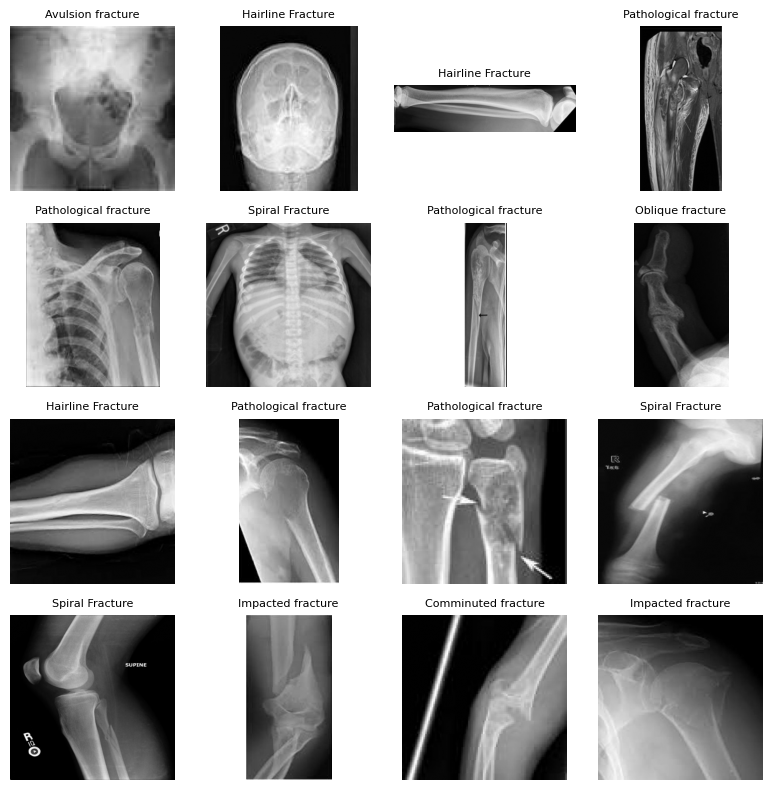

In [ ]:
# Visualize Image

n_rows = 4
n_cols = 4
f, axarr = plt.subplots(n_rows, n_cols, figsize=(8, 8))

for row in range(n_rows):
    for col in range(n_cols):
        sample = data_df.sample(n=1).iloc[0]
        image = Image.open(sample['image_paths']).convert("L")

        label = sample['labels']

        axarr[row, col].imshow(image, cmap='grey')
        axarr[row, col].set_title(f"{label}", fontsize=8)
        axarr[row, col].axis('off')

plt.tight_layout()

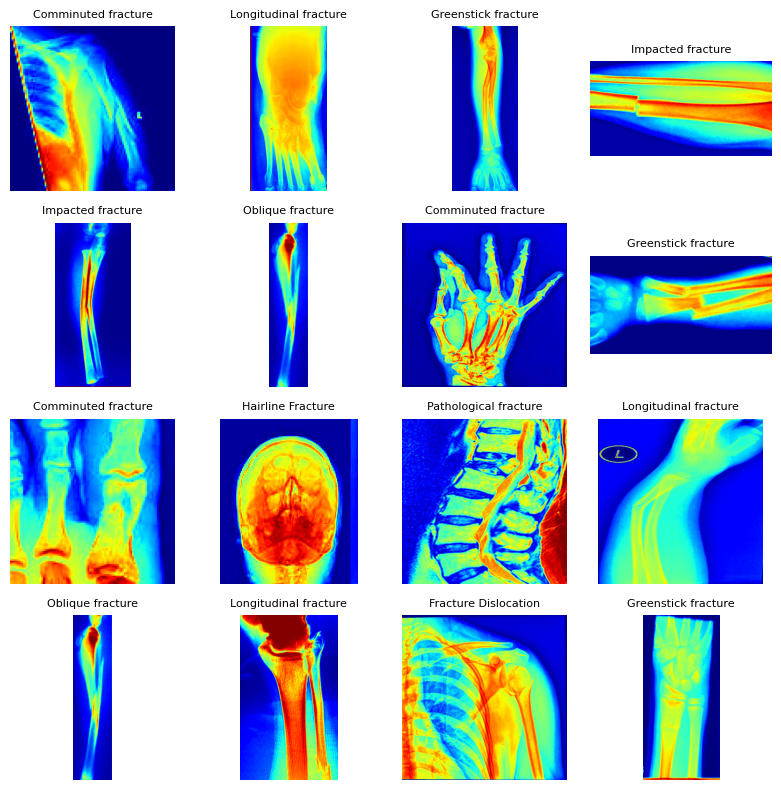

In [ ]:
n_rows = 4
n_cols = 4
f, axarr = plt.subplots(n_rows, n_cols, figsize=(8, 8))

for row in range(n_rows):
    for col in range(n_cols):
        sample = data_df.sample(n=1).iloc[0]
        image = Image.open(sample['image_paths']).convert("L")

        label = sample['labels']

        axarr[row, col].imshow(image, cmap='jet')
        axarr[row, col].set_title(f"{label}", fontsize=8)
        axarr[row, col].axis('off')

plt.tight_layout()

In [ ]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 100

In [ ]:
# create objects of it to simplify the training by DataLoader from torch
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size = 3, padding = 1)
        self.bn1   = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1)
        self.bn2   = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size = 3, padding = 1)
        self.bn3   = nn.BatchNorm2d(128)

        self.pooling = nn.MaxPool2d(2,2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear((128 * 16 * 16), 128)
        self.output = nn.Linear(128, len(data_df['labels'].unique())) # Output

    def forward(self, x):
      x = self.pooling(self.relu(self.bn1(self.conv1(x))))
      x = self.pooling(self.relu(self.bn2(self.conv2(x))))
      x = self.pooling(self.relu(self.bn3(self.conv3(x))))
      x = self.flatten(x)
      x = self.relu(self.linear(x))
      x = self.output(x)
      return x

In [ ]:
model = Net().to(device)

In [ ]:
from torchsummary import summary
summary(model, input_size = (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              ReLU-3         [-1, 32, 128, 128]               0
         MaxPool2d-4           [-1, 32, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          18,496
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
         MaxPool2d-8           [-1, 64, 32, 32]               0
            Conv2d-9          [-1, 128, 32, 32]          73,856
      BatchNorm2d-10          [-1, 128, 32, 32]             256
             ReLU-11          [-1, 128, 32, 32]               0
        MaxPool2d-12          [-1, 128, 16, 16]               0
          Flatten-13                [-1, 32768]               0
           Linear-14                  [

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)

In [ ]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []



In [ ]:
# Training and Validating
for epoch in range(EPOCHS):
  model.train()
  total_acc_train = 0
  total_loss_train = 0

  for inputs, labels in train_loader:
    optimizer.zero_grad()
    # Forward
    outputs = model(inputs)
    train_loss = criterion(outputs, labels)
    total_loss_train += train_loss.item()
    # Backward
    train_loss.backward()
    train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
    total_acc_train += train_acc
    optimizer.step()

  model.eval()
  total_loss_val = 0
  total_acc_val = 0

  with torch.no_grad(): # Validation we will not use optimizer
    for inputs, labels in val_loader:
      outputs = model(inputs)
      val_loss = criterion(outputs, labels)
      total_loss_val += val_loss.item()

      val_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
      total_acc_val += val_acc

  total_loss_train_plot.append(total_loss_train / len(train_loader))
  total_loss_validation_plot.append(total_loss_val / len(val_loader))
  total_acc_train_plot.append((total_acc_train / len(train_dataset)) * 100)
  total_acc_validation_plot.append((total_acc_val / len(val_dataset)) * 100)

  epoch_train_loss = total_loss_train / len(train_loader)
  epoch_val_loss = total_loss_val / len(val_loader)
  epoch_train_acc = (total_acc_train / len(train_dataset)) * 100
  epoch_val_acc = (total_acc_val / len(val_dataset)) * 100

  print(f"Epoch {epoch+1}: Train Loss: {epoch_train_loss:.4f}, Acc: {epoch_train_acc:.2f}%")
  print(f"          Val Loss: {epoch_val_loss:.4f}, Acc: {epoch_val_acc:.2f}%")
  print("="*25)

Epoch 1: Train Loss: 2.3501, Acc: 14.05%
          Val Loss: 2.2468, Acc: 18.24%
Epoch 2: Train Loss: 2.2343, Acc: 18.23%
          Val Loss: 2.2384, Acc: 16.47%
Epoch 3: Train Loss: 2.1967, Acc: 20.00%
          Val Loss: 2.2567, Acc: 17.06%
Epoch 4: Train Loss: 2.1591, Acc: 23.54%
          Val Loss: 2.1750, Acc: 22.35%
Epoch 5: Train Loss: 2.0932, Acc: 26.58%
          Val Loss: 2.1706, Acc: 20.59%
Epoch 6: Train Loss: 2.0590, Acc: 27.22%
          Val Loss: 2.2194, Acc: 20.59%
Epoch 7: Train Loss: 2.0407, Acc: 28.73%
          Val Loss: 2.2663, Acc: 18.24%
Epoch 8: Train Loss: 2.0134, Acc: 27.59%
          Val Loss: 2.2030, Acc: 21.76%
Epoch 9: Train Loss: 1.9835, Acc: 30.25%
          Val Loss: 2.2301, Acc: 19.41%
Epoch 10: Train Loss: 1.9230, Acc: 32.66%
          Val Loss: 2.1927, Acc: 23.53%
Epoch 11: Train Loss: 1.9071, Acc: 33.92%
          Val Loss: 2.2282, Acc: 25.29%
Epoch 12: Train Loss: 1.8583, Acc: 36.33%
          Val Loss: 2.3451, Acc: 20.00%
Epoch 13: Train Loss: 1.8

In [ ]:
# Test
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for inputs, labels in test_loader:
    predictions = model(inputs)

    acc = (torch.argmax(predictions, axis = 1) == labels).sum().item()
    total_acc_test += acc
    test_loss = criterion(predictions, labels)
    total_loss_test += test_loss.item()

print(f"Accuracy Score is: {round((total_acc_test/test_dataset.__len__()) * 100, 4)} and Loss is {round(total_loss_test/1000, 4)}")

Accuracy Score is: 38.4615 and Loss is 0.0294


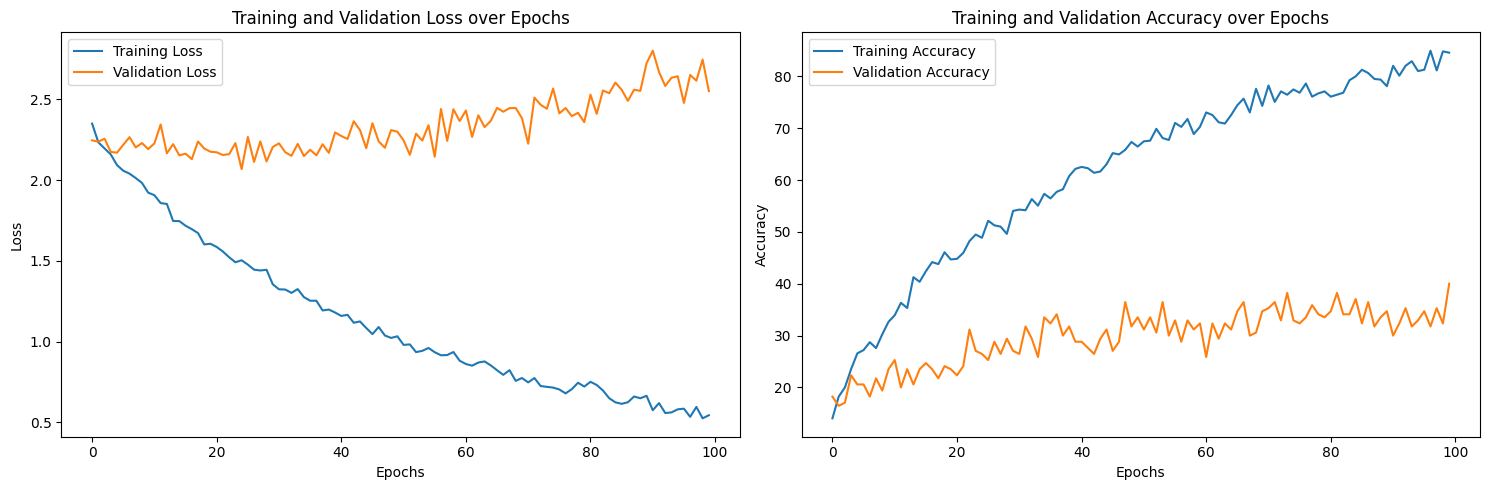

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()

plt.show()

In [ ]:
num_classes = len(data_df['labels'].unique())

model = models.resnet34(pretrained=True)
model = model.to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 203MB/s]


In [ ]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
summary(model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

In [ ]:
# Replace Final Layer
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes).to(device)

In [ ]:
for param in model.parameters():
    param.requires_grad = False

for param in model.layer4.parameters():
    param.requires_grad = True

for param in model.fc.parameters():
    param.requires_grad = True

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    [
    {'params': model.layer4.parameters(), 'lr': 1e-4},
    {'params': model.fc.parameters(), 'lr': 1e-3},]
)

In [ ]:
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return total_loss / len(loader), correct / total

In [ ]:
def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return total_loss / len(loader), correct / total

In [ ]:
EPOCHS = 50
train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch(
        model, train_loader, optimizer, criterion, device
    )
    val_loss, val_acc = validate(
        model, val_loader, criterion, device
    )
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")
    print("="*25)


Epoch 1/50
Train Loss: 2.2961 | Train Acc: 0.2101
Val   Loss: 2.1045 | Val   Acc: 0.3000
Epoch 2/50
Train Loss: 1.7913 | Train Acc: 0.3835
Val   Loss: 2.1670 | Val   Acc: 0.2529
Epoch 3/50
Train Loss: 1.5677 | Train Acc: 0.4722
Val   Loss: 2.0587 | Val   Acc: 0.3118
Epoch 4/50
Train Loss: 1.3659 | Train Acc: 0.5354
Val   Loss: 2.0053 | Val   Acc: 0.2941
Epoch 5/50
Train Loss: 1.1766 | Train Acc: 0.6000
Val   Loss: 2.1591 | Val   Acc: 0.3235
Epoch 6/50
Train Loss: 1.0369 | Train Acc: 0.6456
Val   Loss: 2.0723 | Val   Acc: 0.3235
Epoch 7/50
Train Loss: 0.9180 | Train Acc: 0.6899
Val   Loss: 2.2089 | Val   Acc: 0.4118
Epoch 8/50
Train Loss: 0.7293 | Train Acc: 0.7494
Val   Loss: 2.0273 | Val   Acc: 0.4059
Epoch 9/50
Train Loss: 0.7386 | Train Acc: 0.7671
Val   Loss: 2.5868 | Val   Acc: 0.3235
Epoch 10/50
Train Loss: 0.6236 | Train Acc: 0.7772
Val   Loss: 2.3454 | Val   Acc: 0.3941
Epoch 11/50
Train Loss: 0.5542 | Train Acc: 0.8139
Val   Loss: 2.6133 | Val   Acc: 0.4353
Epoch 12/50
Train L

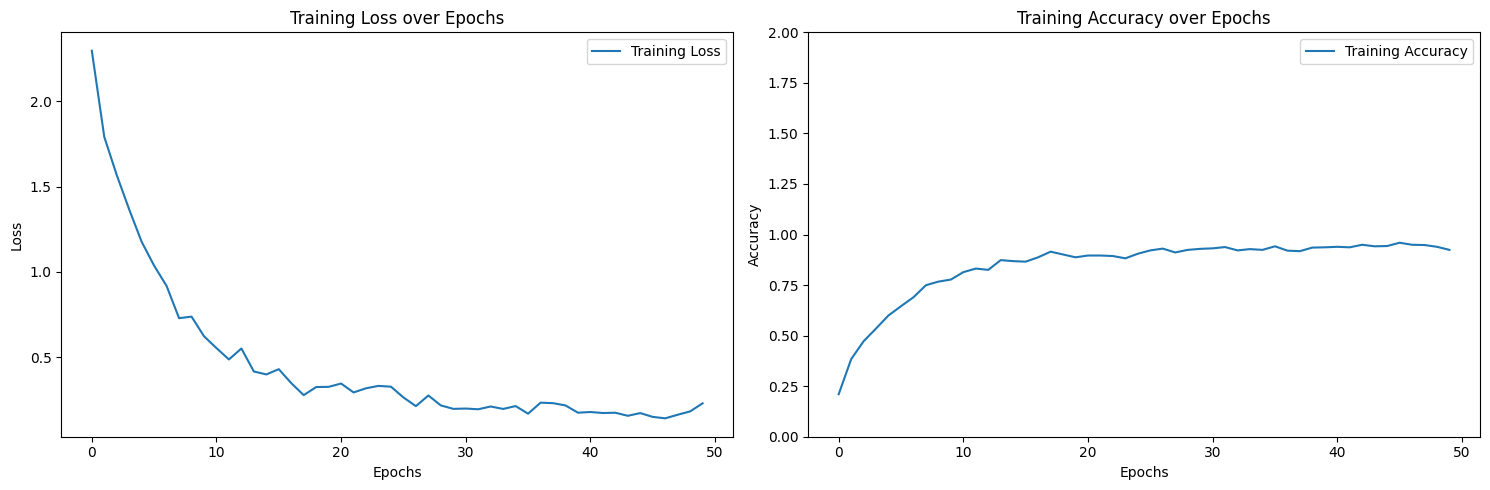

In [ ]:
#Plot

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(train_losses, label='Training Loss')
axs[0].set_title('Training Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[1].set_ylim([0, 2])
axs[0].legend()

axs[1].plot(train_accs, label='Training Accuracy')
axs[1].set_title('Training Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()

plt.show()

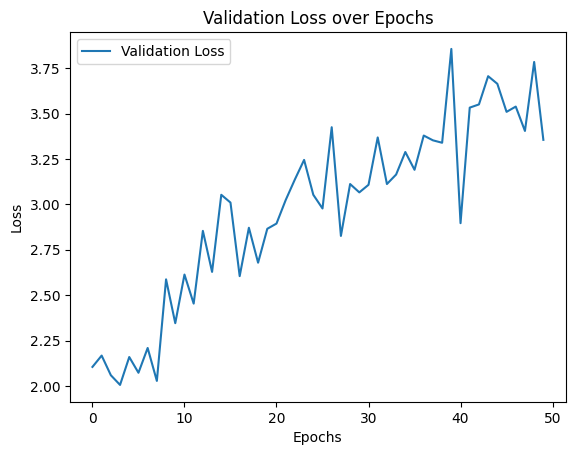

In [ ]:
# Plot validation
plt.plot(val_losses, label='Validation Loss')
plt.title('Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
num_classes = len(data_df['labels'].unique())
num_class

10

In [ ]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 100

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
googlenet_model = models.googlenet(pretrained=True)
googlenet_model = googlenet_model.to(device)

for param in googlenet_model.parameters():
  param.requires_grad = False

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
print(googlenet_model)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [ ]:
googlenet_model.fc = nn.Linear(googlenet_model.fc.in_features, num_classes)
googlenet_model.fc.to(device)

Linear(in_features=1024, out_features=10, bias=True)

In [ ]:
for param in googlenet_model.inception4e.parameters():
  param.requires_grad = True

for param in googlenet_model.inception5a.parameters():
  param.requires_grad = True

for param in googlenet_model.inception5b.parameters():
  param.requires_grad = True

for param in googlenet_model.fc.parameters():
  param.requires_grad = True

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(
    filter(lambda p: p.requires_grad, googlenet_model.parameters()), lr=1e-4
                 )

In [ ]:
train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch(googlenet_model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = validate(googlenet_model, val_loader, criterion, device)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")
    print("="*25)

Epoch 1/100
Train Loss: 2.2689 | Train Acc: 0.1544
Val   Loss: 2.1932 | Val   Acc: 0.1882
Epoch 2/100
Train Loss: 2.1395 | Train Acc: 0.2139
Val   Loss: 2.1491 | Val   Acc: 0.2294
Epoch 3/100
Train Loss: 2.0479 | Train Acc: 0.3063
Val   Loss: 2.0886 | Val   Acc: 0.3118
Epoch 4/100
Train Loss: 1.9635 | Train Acc: 0.3582
Val   Loss: 2.0590 | Val   Acc: 0.2529
Epoch 5/100
Train Loss: 1.8856 | Train Acc: 0.3595
Val   Loss: 2.0311 | Val   Acc: 0.2706
Epoch 6/100
Train Loss: 1.7868 | Train Acc: 0.4076
Val   Loss: 2.0166 | Val   Acc: 0.3235
Epoch 7/100
Train Loss: 1.7122 | Train Acc: 0.4241
Val   Loss: 1.9694 | Val   Acc: 0.3471
Epoch 8/100
Train Loss: 1.6135 | Train Acc: 0.4722
Val   Loss: 1.9023 | Val   Acc: 0.3647
Epoch 9/100
Train Loss: 1.5786 | Train Acc: 0.4759
Val   Loss: 1.9611 | Val   Acc: 0.3294
Epoch 10/100
Train Loss: 1.4986 | Train Acc: 0.5177
Val   Loss: 1.8840 | Val   Acc: 0.3647
Epoch 11/100
Train Loss: 1.4451 | Train Acc: 0.5316
Val   Loss: 1.8267 | Val   Acc: 0.3706
Epoch 12

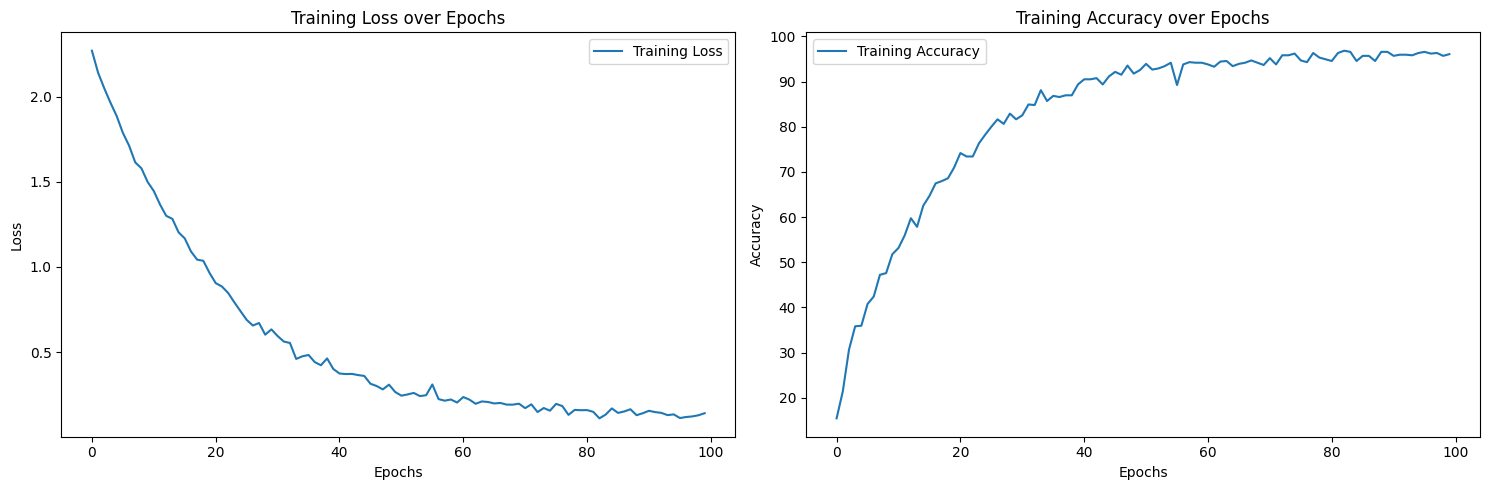

In [ ]:
#Plot
train_accs = np.array(train_accs) * 100
train_losses = np.array(train_losses)
val_accs = np.array(val_accs) * 100
val_losses = np.array(val_losses)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Plot Training Loss
axs[0].plot(train_losses, label='Training Loss')
axs[0].set_title('Training Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot Training Accuracy
axs[1].plot(train_accs, label='Training Accuracy')
axs[1].set_title('Training Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()
plt.show()

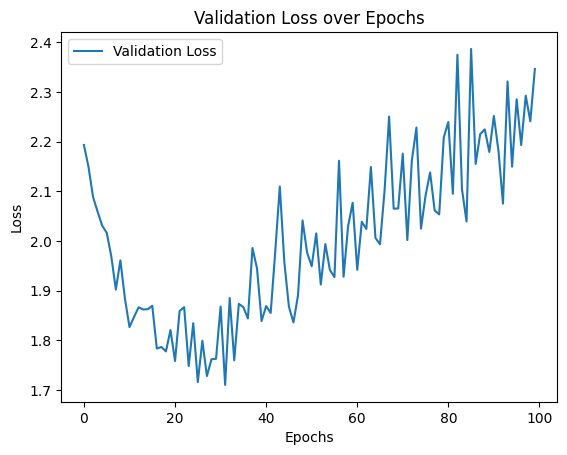

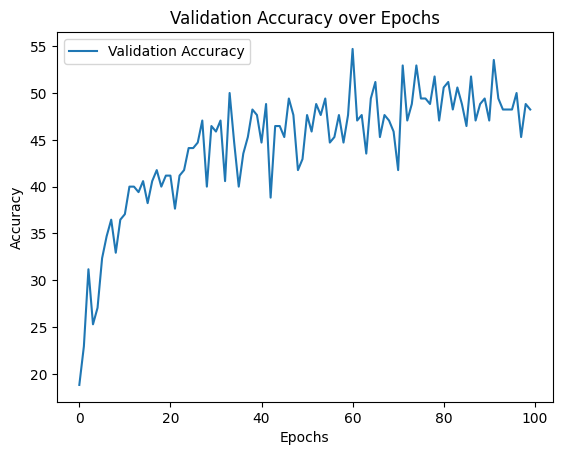

In [ ]:
plt.plot(val_losses, label='Validation Loss')
plt.title('Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plot val_acc

plt.plot(val_accs, label='Validation Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
len(data_df)

1129

In [ ]:
weights = models.EfficientNet_B3_Weights.IMAGENET1K_V1
model_eb3 = models.efficientnet_b3(weights=weights)

In [ ]:
model_eb3 = model_eb3.to(device)

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.RandomAffine(
        degrees=0,
        translate=(0.05, 0.05),
        scale=(0.95, 1.05)
    ),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
    transforms.ConvertImageDtype(torch.float)
    ])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
     transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
    transforms.ConvertImageDtype(torch.float)])

In [ ]:
print(model_eb3)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [ ]:
for param in model_eb3.features.parameters():
    param.requires_grad = False

In [ ]:
model_eb3.classifier[1] = nn.Linear(model_eb3.classifier[1].in_features, num_class).to(device)

In [ ]:
optimizer = torch.optim.Adam(model_eb3.classifier.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [ ]:
train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch(model_eb3, train_loader, optimizer, criterion, device)
    val_loss, val_acc = validate(model_eb3, val_loader, criterion, device)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")
    print("="*25)

Epoch 1/100
Train Loss: 2.2753 | Train Acc: 0.1418
Val   Loss: 2.2069 | Val   Acc: 0.2294
Epoch 2/100
Train Loss: 2.1697 | Train Acc: 0.2316
Val   Loss: 2.1958 | Val   Acc: 0.2176
Epoch 3/100
Train Loss: 2.0723 | Train Acc: 0.2747
Val   Loss: 2.2916 | Val   Acc: 0.2118
Epoch 4/100
Train Loss: 2.0271 | Train Acc: 0.3190
Val   Loss: 2.1219 | Val   Acc: 0.2529
Epoch 5/100
Train Loss: 2.0003 | Train Acc: 0.3076
Val   Loss: 2.1090 | Val   Acc: 0.2412
Epoch 6/100
Train Loss: 1.9438 | Train Acc: 0.3380
Val   Loss: 2.0908 | Val   Acc: 0.2647
Epoch 7/100
Train Loss: 1.9503 | Train Acc: 0.3329
Val   Loss: 2.1939 | Val   Acc: 0.2588
Epoch 8/100
Train Loss: 1.9297 | Train Acc: 0.3203
Val   Loss: 2.6464 | Val   Acc: 0.2824
Epoch 9/100
Train Loss: 1.8908 | Train Acc: 0.3595
Val   Loss: 2.2030 | Val   Acc: 0.2647
Epoch 10/100
Train Loss: 1.8496 | Train Acc: 0.3392
Val   Loss: 2.1319 | Val   Acc: 0.2647
Epoch 11/100
Train Loss: 1.8805 | Train Acc: 0.3684
Val   Loss: 2.5590 | Val   Acc: 0.2000
Epoch 12